In [80]:
# Import Packages
import os
# Change to the working directory
os.chdir('/Users/zepedalab/Desktop/MATHia_NLP_YB')
#Lab Laptop wd:/Users/zepedalab/Desktop/MATHia_NLP_YB
#Home Desktop wd: /Users/yuchengbao/Desktop/ALL Lab/MATHia_NLP

import pandas as pd
import re
import spacy
#!python3 -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/zepedalab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl (400.7 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [81]:
# Import Data File
text_df = pd.read_excel('/Users/zepedalab/Desktop/MATHia_NLP_YB/E1C3 Codes + partial E2C3.xlsx')

In [82]:
# Pre-process the text data (text_df)
# Convert the text input to the lower case string
# Remove all non-alphabetic characters
text_df['input'] = text_df['input'].astype(str)
text_df['input'] = text_df['input'].str.lower()
text_df['input'] = text_df['input'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
# Filter out any input that comprise less than 3 characters
text_df = text_df[text_df['input'].str.len() >= 3]
short_input_df = text_df[text_df['input'].str.len() < 3] #short_input_df allows us to manually check

In [83]:
# Detecting the nonsense string
from nostril import nonsense
short_indices = []
nonsense_indices = []

# Iterate through rows and separate nonsense rows
for index, row in text_df.iterrows():
    try:
        text = row['input']
        if len(text) < 6: # Check if the text is too short to test
            # Add the short text to short_text_df
            if len(text) < 6:
                short_indices.append(index)
            continue

        # Use nostril to detect nonsense in the current row's text
        if nonsense(text):
            nonsense_indices.append(index)

    except Exception as e:
        msg = str(e)
        if "Text is too short to test" in msg:
             short_indices.append(index)
        else:
            print(f"Error processing row {index}: {e}")

short_text_df = text_df.loc[short_indices]
nonsense_df = text_df.loc[nonsense_indices]
text_df = text_df.drop(nonsense_indices)

In [84]:
# Quicklook on the nonsense string
nonsense_df.input[:10]

4                                  jjjnnknjmimkkikiilkin
99                                           ummmmmm idk
103    jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj...
159                                              yayyyyy
162    dddddddddddddddddddddddddddddddddddddddddddddd...
263                            iiiiiiiiiiiiiiiiiiiiii kj
359                                           v guvghibj
463                                             ndcfksdj
480                                   ibhuiygutgcytuyvjh
505                                               jkkkkk
Name: input, dtype: object

In [85]:
# Pre-process those shor input by using the gibberish detector
from gibberish_detector import detector
#os.chdir('/Users/yuchengbao/Desktop/ALL Lab/MATHia_NLP')
#os.system('gibberish-detector train big.txt > gibberish-detector.model')
Detector = detector.create_from_model('/Users/zepedalab/PycharmProjects/MATHia-NLP-YB/gibberish-detector.model')
#lab wd: /Users/zepedalab/PycharmProjects/MATHia-NLP-YB/gibberish-detector.model

In [86]:
gibberish_indices = []

# Iterate through rows and separate gibberish rows
for index, row in text_df.iterrows():
    try:
        # Check if the row is gibberish
        is_gibberish = Detector.is_gibberish(row['input'])

        # If it is gibberish, add to the gibberish_df and remove from text_df_3
        if is_gibberish:
            gibberish_indices.append(index)

    except Exception as e:
        print(f"Error processing row {index}: {e}")

gibberish_df = text_df.loc[gibberish_indices]
text_df = text_df.drop(gibberish_indices)

In [87]:
# Quicklook on the gibberish string
gibberish_df.input[:10]

93      bruhhhh
111    r gtktnq
113         idk
190         idk
191         idk
193         kjh
213        kklj
246         idk
254        jhgj
258         idk
Name: input, dtype: object

In [88]:
# Import necessary packages for the later NLP analysis
import gensim
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Download the wordnet resource if not already done
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zepedalab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zepedalab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Tokenize and lemmatize the documents
tokenized_docs = [
    [lemmatizer.lemmatize(word.lower()) for word in gensim.utils.tokenize(doc)
     if word.lower() not in stop_words and word.isalpha()]
    for doc in text_df.input
    if len([word for word in gensim.utils.tokenize(doc) if word.lower() not in stop_words and word.isalpha()]) > 0
]

# Create filtered_docs: Only keep non-empty documents
filtered_docs = [doc for doc in tokenized_docs if len(doc) > 0]

# Filter text_df to remove rows that correspond to empty tokenized documents
# Ensure that text_df_filtered matches filtered_docs in length
text_df_filtered = text_df.iloc[:len(filtered_docs)].reset_index(drop=True)

In [90]:
print(text_df_filtered.columns)

Index(['Anon.Student.Id', 'input', 'Invalid Response', 'Self-Efficacy',
       'Utility Value', 'Intrinsic Values (replaced Interest Enhancement)',
       'Opportunity cost \n(outside effort cost)', 'Effort',
       'Extrinsic Rewards/ Self-Consequating', 'Environmental Control',
       'Motivation for Others', 'Mastery Self-Talk (Approach/Avoidance)',
       'Performance Self-Talk (Approach/Avoidance)', 'Fear of Failure',
       'Attention', 'Willpower', 'Seeking help from others',
       'Emotion Regulation', 'Did Not Motivate', 'I Don't Know',
       'No Strategy Listed'],
      dtype='object')


In [91]:
# create empty dictionary from gensim library (for the vocabulary)
dictionary = gensim.corpora.Dictionary()
# iteratively add each doc to the bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in filtered_docs]

In [92]:
import numpy as np

# Get vocab from dictionary
vocab = pd.Series(dictionary.token2id).index

# Sequence of numbers as long as the documents
index = range(len(bow_corpus))

# Create a pandas dataframe full of zeros.
bow_df = pd.DataFrame(data=np.zeros((len(bow_corpus), len(dictionary)), dtype=np.float32),
                  index=index, # row labels
                  columns=vocab) #column labels

# Add each word from the bag-of-words corpus to the matrix.
for idx in index:
  for id, freq in bow_corpus[idx]:
    bow_df.loc[idx,dictionary[id]] = freq

# Transpose the matrix for easy reading
bow_df

,awaly,better,last,time,nan,ask,class,classmate,fellow,focus,...,explaining,enough,pay,sucessful,belving,motavited,unit,went,push,continue
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# Calculating Inverse Document Frequency
num_documents = len(bow_df) #get the length of the documents

# function of idf
def idf(term):
  documents_containing_term = (bow_df[term] > 0).sum()    # sum of documents containing the term
  return np.log(num_documents+1/documents_containing_term+1)  # divide the number of documents by the num documents with the term and get the log.

# dictionary comprehension to apply the idf function to every word (column) in the bow_df DataFrame
idf = pd.Series({term:idf(term) for term in bow_df.columns}) # create dictionary with key value pair of term:idf(term)

#Calculate Term Frequency
# divide each token count by the total token count for the row.
tf_df = bow_df.div(bow_df.sum(axis='columns'), axis='rows')

#Calculate the TF-IDF score
tfidf_df = tf_df.copy().multiply(idf, axis='columns')
# make copy of tf_df that is tf/idf

# Quick view on tf-idf metrix
tfidf_df[:10]



,awaly,better,last,time,nan,ask,class,classmate,fellow,focus,...,explaining,enough,pay,sucessful,belving,motavited,unit,went,push,continue
0,1.584206,1.583819,1.583911,1.583804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,6.335073,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,6.335073,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,6.335073,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.407856,0.703923,0.703993,0.704092,0.703913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Willpower
0    459
1    104
Name: count, dtype: int64

Balanced class counts:
Willpower
1    104
0    104
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.8846153846153846
Logistic Regression Precision (Balanced Data): 0.8389830508474576
Logistic Regression Recall (Balanced Data): 0.9519230769230769

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.94      0.82      0.88       104
           1       0.84      0.95      0.89       104

    accuracy                           0.88       208
   macro avg       0.89      0.88      0.88       208
weighted avg       0.89      0.88      0.88       208



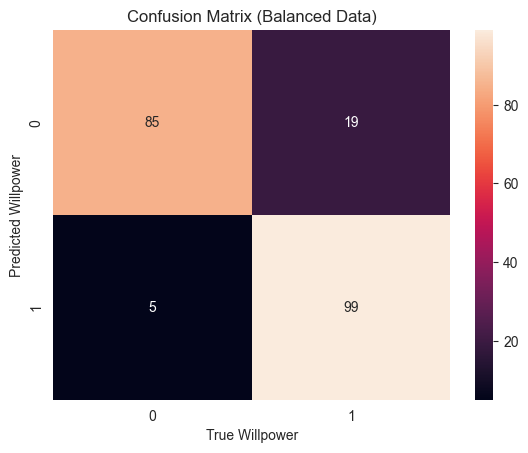

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Select the target human code
y_raw = text_df_filtered['Willpower']

# Make sure X (tfidf_df) and y share the same indices
valid_idx = tfidf_df.index.intersection(y_raw.index)

X = tfidf_df.loc[valid_idx]
y = y_raw.loc[valid_idx]
print(y.value_counts())

# Build a balanced sub-dataset with equal number of sample coded as 0 and 1

class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
n_minority = class_counts.min()

# Indices for each class
minority_idx = y[y == minority_class].index
majority_idx_sampled = y[y == majority_class].sample(
    n=n_minority,
    random_state=12434  # reproducibility
).index

balanced_idx = minority_idx.union(majority_idx_sampled)

X_bal = X.loc[balanced_idx]
y_bal = y.loc[balanced_idx]

# Shuffle rows
X_bal, y_bal = shuffle(X_bal, y_bal, random_state=14312)

print("\nBalanced class counts:")
print(y_bal.value_counts())

#Using the balanced dataset to train the machine learning logistic regression model

bal_classifier = LogisticRegression(max_iter=1000)
bal_classifier.fit(X_bal, y_bal)

print("\nClasses in classifier:", bal_classifier.classes_)

# Predict on balanced data (for quick check)
predicted_bal = bal_classifier.predict(X_bal)

# Print out the evaluation metrics

print("\nLogistic Regression Accuracy (Balanced Data):",
      metrics.accuracy_score(y_bal, predicted_bal))
print("Logistic Regression Precision (Balanced Data):",
      metrics.precision_score(y_bal, predicted_bal))
print("Logistic Regression Recall (Balanced Data):",
      metrics.recall_score(y_bal, predicted_bal))

print("\nClassification Report (Balanced Data):\n",
      metrics.classification_report(y_bal, predicted_bal))

# Confusion matrix
cm_bal = metrics.confusion_matrix(y_bal, predicted_bal)

sns.heatmap(cm_bal, annot=True, fmt='d')
plt.title('Confusion Matrix (Balanced Data)')
plt.xlabel('True Willpower')
plt.ylabel('Predicted Willpower')
plt.show()


In [121]:
# Print out the logistic coefficients for the top word list
# For binary classification in sklearn:
# bal_classifier.coef_[0] corresponds to the negative class (0) in bal_classifier.classes_
positive_class = bal_classifier.classes_[1]

coef = bal_classifier.coef_[0]         # shape: (n_features,)
feature_names = X_bal.columns          # TF-IDF feature names

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
})

# Sort descending: largest positive coefficients first
coef_df_sorted = coef_df.sort_values(by='coefficient', ascending=False)

# Top words predicting the positive_class and negative_class (Top 20 for each)
top_20_pos = coef_df_sorted.head(20)
top_20_neg = coef_df_sorted.tail(20)


highest_20 = top_20_pos.reset_index(drop=True)
lowest_20 = top_20_neg.reset_index(drop=True)

highest_20.columns = [col + "_pos" for col in highest_20.columns]
lowest_20.columns = [col + "_neg" for col in lowest_20.columns]

coef_compare = pd.concat([highest_20, lowest_20], axis=1)

print("Top 20 positive and negative predictors for Willpower:")
print(coef_compare)

Top 20 positive and negative predictors for Willpower:
   feature_pos  coefficient_pos  feature_neg  coefficient_neg
0        focus         1.024687          use        -0.439765
1    improving         0.989208       myslef        -0.441163
2         dont         0.911352         calm        -0.450773
3       trying         0.691945        eagle        -0.466036
4         said         0.676812      academy        -0.466101
5         done         0.669538        solve        -0.469132
6    realizing         0.640896    finishing        -0.480019
7     question         0.622145         help        -0.484462
8        would         0.606577       harder        -0.485194
9           ok         0.578578      keeping        -0.496969
10       stuck         0.554590    something        -0.504390
11     teacher         0.550984   motivation        -0.513434
12     thought         0.542113          idk        -0.515229
13       never         0.539773      reading        -0.527796
14      worked 

In [122]:
# Print out more positive and negative predictor words
pos_df = coef_df_sorted[coef_df_sorted['coefficient'] > 0].copy()
neg_df = coef_df_sorted[coef_df_sorted['coefficient'] < 0].copy()

pos_words = pos_df['feature'].tolist()
neg_words = neg_df['feature'].tolist()

print("\nFirst top 50 positive words for Willpower:")
print(pos_words[:50])

print("\nFirst top 50 negative words for Willpower:")
print(neg_words[:50])


First top 50 positive words for Willpower:
['focus', 'improving', 'dont', 'trying', 'said', 'done', 'realizing', 'question', 'would', 'ok', 'stuck', 'teacher', 'thought', 'never', 'worked', 'super', 'told', 'need', 'people', 'se', 'everything', 'cant', 'sooner', 'smarter', 'candy', 'thanks', 'ertyuio', 'solved', 'guessing', 'bobathan', 'idl', 'tried', 'ask', 'give', 'belving', 'jusr', 'learnes', 'knowledge', 'twostep', 'w', 'cooked', 'felt', 'always', 'torcher', 'motivated', 'keept', 'okay', 'bit', 'cause', 'lisin']

First top 50 negative words for Willpower:
['hard', 'best', 'instead', 'used', 'math', 'self', 'mativate', 'someing', 'grinding', 'way', 'go', 'zero', 'nkt', 'better', 'giveing', 'im', 'say', 'th', 'highschool', 'leanr', 'scholerships', 'think', 'motivates', 'skill', 'someone', 'theyre', 'typically', 'waht', 'highlight', 'consider', 'streghths', 'well', 'much', 'number', 'maybe', 'tofay', 'worth', 'hecking', 'hit', 'get', 'l', 'understanding', 'attempting', 'ill', 'tring'


=== Final model for predicting Willpower using top 50 positive + top 50 negative words ===
Total usable features: 100
Accuracy: 0.7692307692307693
Precision: 0.8414634146341463
Recall: 0.6634615384615384

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       104
           1       0.84      0.66      0.74       104

    accuracy                           0.77       208
   macro avg       0.78      0.77      0.77       208
weighted avg       0.78      0.77      0.77       208



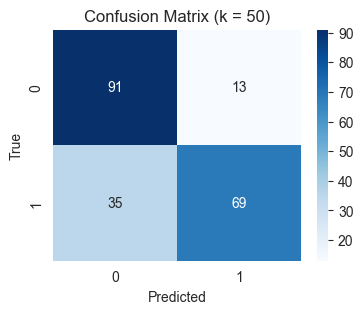

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
#Prediction evaluation with top 50 positive and negative words
def evaluate_final_k(X_bal, y_bal, pos_words, neg_words):
    k = 50
    print(f"\n=== Final model for predicting Willpower using top {k} positive + top {k} negative words ===")

    # Select the top 50 pos + 50 neg words
    pos_k = pos_words[:k]
    neg_k = neg_words[:k]
    selected_features = pos_k + neg_k

    # Ensure the selected features exist in TF-IDF columns
    selected_features = [w for w in selected_features if w in X_bal.columns]
    print(f"Total usable features: {len(selected_features)}")

    # Subset TF-IDF matrix
    X_sub = X_bal[selected_features]

    # Train logistic regression on full dataset
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_sub, y_bal)

    # Predict on training data (you can later swap to test set if needed)
    y_pred = clf.predict(X_sub)

    # Evaluation metrics
    print("Accuracy:", metrics.accuracy_score(y_bal, y_pred))
    print("Precision:", metrics.precision_score(y_bal, y_pred))
    print("Recall:", metrics.recall_score(y_bal, y_pred))
    print("\nClassification Report:\n",
          metrics.classification_report(y_bal, y_pred))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_bal, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix (k = 50)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return clf, selected_features, cm

# Run final model
clf_50, features_50, cm_50 = evaluate_final_k(
    X_bal=X_bal,
    y_bal=y_bal,
    pos_words=pos_words,
    neg_words=neg_words
)

In [126]:
import spacy
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
from itertools import combinations


top50_pos = pos_words[:50]

# Make one anchor doc out of the 50 words
anchor_doc = nlp(" ".join(top50_pos))

# ---------------------------
# 2. Get response texts aligned with valid_idx
# ---------------------------

TEXT_COL = "input"  # change to your actual text column name
response_texts = text_df_filtered.loc[valid_idx, TEXT_COL].astype(str)

# -----------------------------------
# 2. Function: internal sentence-pair similarity
# -----------------------------------

def get_internal_similarity(text):
    doc = nlp(text)
    sents = list(doc.sents)

    # If only 1 sentence, similarity = 0 (or np.nan)
    if len(sents) < 2:
        return np.nan

    similarities = []

    # compare ALL pairs: (0,1), (0,2), (1,2), (1,3), ...
    for s1, s2 in combinations(sents, 2):
        sim = s1.similarity(s2)
        similarities.append(sim)

    # return mean similarity of all sentence pairs
    return np.mean(similarities)

# -----------------------------------
# 3. Compute similarity for each response
# -----------------------------------

semantic_scores = []
for txt in response_texts:
    sim = get_internal_similarity(txt)
    semantic_scores.append(sim)

# ---------------------------
# 4. Build results_df (keep index so we can use balanced_idx)
# ---------------------------

results_df = pd.DataFrame({
    "response_text": response_texts,
    "Willpower": y.loc[valid_idx],
    "semantic_sim": semantic_scores
}, index=valid_idx)

# 5B. T-test on BALANCED subset (optional)
# ---------------------------
# This assumes you already defined `balanced_idx` earlier when you made X_bal, y_bal

results_bal = results_df.loc[balanced_idx].dropna()

sim_1_bal = results_bal.loc[results_bal["Willpower"] == 1, "semantic_sim"]
sim_0_bal = results_bal.loc[results_bal["Willpower"] == 0, "semantic_sim"]

t_bal, p_bal = ttest_ind(sim_1_bal, sim_0_bal, equal_var=False)

print("\nT-test (BALANCED DATA)")
print(f"T = {t_bal:.4f}, p = {p_bal:.4f}")
print(f"Mean_1 = {sim_1_bal.mean():.4f}, Mean_0 = {sim_0_bal.mean():.4f}")

/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_66931/2944147662.py:36: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  sim = s1.similarity(s2)



T-test (BALANCED DATA)
T = 1.0192, p = 0.4937
Mean_1 = 0.9076, Mean_0 = 0.4494


Performance Self-Talk

Performance Self-Talk (Approach/Avoidance)
0    514
1     49
Name: count, dtype: int64

Balanced class counts:
Performance Self-Talk (Approach/Avoidance)
0    49
1    49
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.8979591836734694
Logistic Regression Precision (Balanced Data): 0.975609756097561
Logistic Regression Recall (Balanced Data): 0.8163265306122449

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.84      0.98      0.91        49
           1       0.98      0.82      0.89        49

    accuracy                           0.90        98
   macro avg       0.91      0.90      0.90        98
weighted avg       0.91      0.90      0.90        98



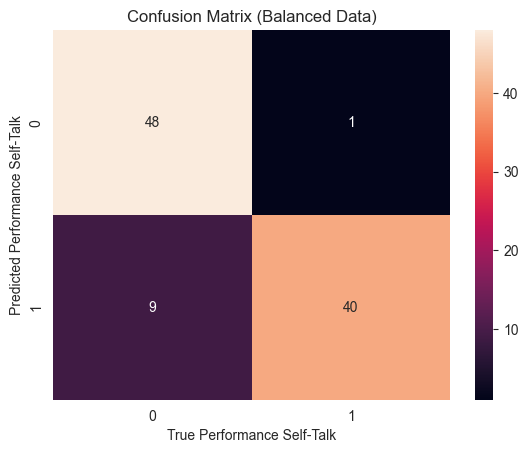


Comparison of top 20 positive and negative predictors for Performance Self-Talk:
    feature_pos  coefficient_pos  feature_neg  coefficient_neg
0          told         0.926543      focused        -0.386997
1          self         0.734955      project        -0.387094
2          best         0.694955      thought        -0.395417
3       problem         0.590236         even        -0.409485
4         topic         0.564433         fail        -0.416587
5         asked         0.536179         else        -0.416635
6         learn         0.478178         high        -0.418452
7       improve         0.459963         play        -0.422084
8       forward         0.458415  grandmother        -0.433569
9       teacher         0.442649         able        -0.441615
10       better         0.431485       unsure        -0.454206
11        might         0.401162      clicked        -0.454206
12        solve         0.394246       pushed        -0.454206
13        class         0.390146    

In [99]:
# hide_input
# Select the target human code
y_raw = text_df_filtered['Performance Self-Talk (Approach/Avoidance)']

# Make sure X (tfidf_df) and y share the same indices
valid_idx = tfidf_df.index.intersection(y_raw.index)

X = tfidf_df.loc[valid_idx]
y = y_raw.loc[valid_idx]
print(y.value_counts())

# Build a balanced sub-dataset with equal number of sample coded as 0 and 1

class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
n_minority = class_counts.min()

# Indices for each class
minority_idx = y[y == minority_class].index
majority_idx_sampled = y[y == majority_class].sample(
    n=n_minority,
    random_state=12434  # reproducibility
).index

balanced_idx = minority_idx.union(majority_idx_sampled)

X_bal = X.loc[balanced_idx]
y_bal = y.loc[balanced_idx]

# Shuffle rows
X_bal, y_bal = shuffle(X_bal, y_bal, random_state=14312)

print("\nBalanced class counts:")
print(y_bal.value_counts())

#Using the balanced dataset to train the machine learning logistic regression model

bal_classifier = LogisticRegression(max_iter=1000)
bal_classifier.fit(X_bal, y_bal)

print("\nClasses in classifier:", bal_classifier.classes_)

# Predict on balanced data (for quick check)
predicted_bal = bal_classifier.predict(X_bal)

# Print out the evaluation metrics

print("\nLogistic Regression Accuracy (Balanced Data):",
      metrics.accuracy_score(y_bal, predicted_bal))
print("Logistic Regression Precision (Balanced Data):",
      metrics.precision_score(y_bal, predicted_bal))
print("Logistic Regression Recall (Balanced Data):",
      metrics.recall_score(y_bal, predicted_bal))

print("\nClassification Report (Balanced Data):\n",
      metrics.classification_report(y_bal, predicted_bal))

# Confusion matrix
cm_bal = metrics.confusion_matrix(y_bal, predicted_bal)

sns.heatmap(cm_bal, annot=True, fmt='d')
plt.title('Confusion Matrix (Balanced Data)')
plt.xlabel('True Performance Self-Talk')
plt.ylabel('Predicted Performance Self-Talk')
plt.show()

# Print out the logistic coefficients for the top word list

# For binary classification in sklearn:
# bal_classifier.coef_[0] corresponds to the SECOND class in bal_classifier.classes_
positive_class = bal_classifier.classes_[1]

coef = bal_classifier.coef_[0]         # shape: (n_features,)
feature_names = X_bal.columns          # TF-IDF feature names

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
})

# Sort descending: largest positive coefficients first
coef_df_sorted = coef_df.sort_values(by='coefficient', ascending=False)

# Top words predicting the positive_class and negative_class (Top 20 for each)
top_20_pos = coef_df_sorted.head(20)
top_20_neg = coef_df_sorted.tail(20)


highest_20 = top_20_pos.reset_index(drop=True)
lowest_20 = top_20_neg.reset_index(drop=True)

highest_20.columns = [col + "_pos" for col in highest_20.columns]
lowest_20.columns = [col + "_neg" for col in lowest_20.columns]

coef_compare = pd.concat([highest_20, lowest_20], axis=1)

print("\nComparison of top 20 positive and negative predictors for Performance Self-Talk:")
print(coef_compare)


In [100]:
# hide_input
#Print out more positive and negative predictor words

# All words with positive coefficients (predict the positive_class)
pos_df = coef_df_sorted[coef_df_sorted['coefficient'] > 0].copy()
neg_df = coef_df_sorted[coef_df_sorted['coefficient'] < 0].copy()

pos_words = pos_df['feature'].tolist()
neg_words = neg_df['feature'].tolist()

print("\nFirst top 50 positive words for Performance Self-Talk:")
print(pos_words[:50])

print("\nFirst top 50 negative words for Performance Self-Talk:")
print(neg_words[:50])


First top 50 positive words for Performance Self-Talk:
['told', 'self', 'best', 'problem', 'topic', 'asked', 'learn', 'improve', 'forward', 'teacher', 'better', 'might', 'solve', 'class', 'yes', 'goal', 'dormir', 'matia', 'distracting', 'clam', 'motivation', 'could', 'saying', 'ok', 'knowing', 'im', 'continue', 'time', 'working', 'little', 'bit', 'skibidi', 'toilet', 'thinking', 'finish', 'motavited', 'didnt', 'star', 'motexvated', 'master', 'test', 'learnes', 'knowledge', 'twostep', 'hated', 'stupid', 'workspace', 'pused', 'pushing', 'hint']

First top 50 negative words for Performance Self-Talk:
['amount', 'dad', 'proud', 'question', 'trying', 'dont', 'easy', 'people', 'used', 'get', 'write', 'kept', 'try', 'way', 'instead', 'someing', 'mativate', 'grinding', 'nan', 'motivate', 'grade', 'music', 'since', 'backround', 'cancel', 'noise', 'around', 'talking', 'infront', 'possible', 'solution', 'correct', 'reread', 'said', 'buy', 'backpack', 'sprayground', 'another', 'mathias', 'complet


=== Final model for predicting Performance Self-talk using top 50 positive + top 50 negative words ===
Total usable features: 100
Accuracy: 0.8775510204081632
Precision: 1.0
Recall: 0.7551020408163265

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        49
           1       1.00      0.76      0.86        49

    accuracy                           0.88        98
   macro avg       0.90      0.88      0.88        98
weighted avg       0.90      0.88      0.88        98


Confusion Matrix:


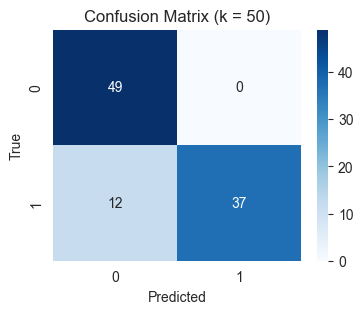

In [101]:
# hide_input
# Final evaluation with k = 50

def evaluate_final_k(X_bal, y_bal, pos_words, neg_words):

    k = 50
    print(f"\n=== Final model for predicting Performance Self-talk using top {k} positive + top {k} negative words ===")

    # Select the top 50 pos + 50 neg words
    pos_k = pos_words[:k]
    neg_k = neg_words[:k]
    selected_features = pos_k + neg_k

    # Ensure the selected features exist in TF-IDF columns
    selected_features = [w for w in selected_features if w in X_bal.columns]
    print(f"Total usable features: {len(selected_features)}")

    # Subset TF-IDF matrix
    X_sub = X_bal[selected_features]

    # Train logistic regression on full dataset
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_sub, y_bal)

    # Predict on training data (you can later swap to test set if needed)
    y_pred = clf.predict(X_sub)

    # Evaluation metrics
    print("Accuracy:", metrics.accuracy_score(y_bal, y_pred))
    print("Precision:", metrics.precision_score(y_bal, y_pred))
    print("Recall:", metrics.recall_score(y_bal, y_pred))
    print("\nClassification Report:\n",
          metrics.classification_report(y_bal, y_pred))

    # 6. Confusion matrix
    cm = metrics.confusion_matrix(y_bal, y_pred)
    print("\nConfusion Matrix:")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix (k = 50)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return clf, selected_features, cm

# Run final model
clf_50, features_50, cm_50 = evaluate_final_k(
    X_bal=X_bal,
    y_bal=y_bal,
    pos_words=pos_words,
    neg_words=neg_words
)


In [102]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# ---------------------------
# 1. Top 50 positive words
# ---------------------------

top50_pos = pos_words[:50]   # already generated above

# ---------------------------
# 2. Load embedding model
# ---------------------------

model = SentenceTransformer('all-MiniLM-L6-v2')

# ---------------------------
# 3. Compute embeddings
# ---------------------------

# Embeddings for the 50 positive predictor words
word_embeddings = model.encode(top50_pos)

# Embedding for each response text
response_texts = text_df_filtered.loc[valid_idx, 'input']
response_embeddings = model.encode(response_texts.tolist())

# ---------------------------
# 4. Compute semantic similarity score for each response
# ---------------------------

# cosine similarity returns (N_responses × 50) matrix
similarity_matrix = cosine_similarity(response_embeddings, word_embeddings)

# mean similarity as the score
semantic_scores = similarity_matrix.mean(axis=1)

# ---------------------------
# 5. Build result dataframe
# ---------------------------

results_df = pd.DataFrame({
    'response_text': response_texts.values,
    'Performance Self-Talk (Approach/Avoidance)': y.values,
    'semantic_sim': semantic_scores
})

# ---------------------------
# 6. Independent samples t-test
# ---------------------------
results_bal = results_df.loc[balanced_idx].copy()

sim_1 = results_bal.loc[results_bal['Performance Self-Talk (Approach/Avoidance)'] == 1, 'semantic_sim']
sim_0 = results_bal.loc[results_bal['Performance Self-Talk (Approach/Avoidance)'] == 0, 'semantic_sim']

t, p = ttest_ind(sim_1, sim_0, equal_var=False)

print("\nT-test comparing Willpower=1 vs Willpower=0 on semantic similarity score (BALANCED DATASET)")
print(f"T = {t:.4f}, p = {p:.4f}")
print(f"Mean(sim_1) = {sim_1.mean():.4f}, Mean(sim_0) = {sim_0.mean():.4f}")



T-test comparing Willpower=1 vs Willpower=0 on semantic similarity score (BALANCED DATASET)
T = -4.0342, p = 0.0001
Mean(sim_1) = 0.1522, Mean(sim_0) = 0.1889


Effort

Effort
0.0    518
1.0     44
Name: count, dtype: int64

Balanced class counts:
Effort
1.0    44
0.0    44
Name: count, dtype: int64

Classes in classifier: [0. 1.]

Logistic Regression Accuracy (Balanced Data): 0.8863636363636364
Logistic Regression Precision (Balanced Data): 0.8269230769230769
Logistic Regression Recall (Balanced Data): 0.9772727272727273

Classification Report (Balanced Data):
               precision    recall  f1-score   support

         0.0       0.97      0.80      0.88        44
         1.0       0.83      0.98      0.90        44

    accuracy                           0.89        88
   macro avg       0.90      0.89      0.89        88
weighted avg       0.90      0.89      0.89        88



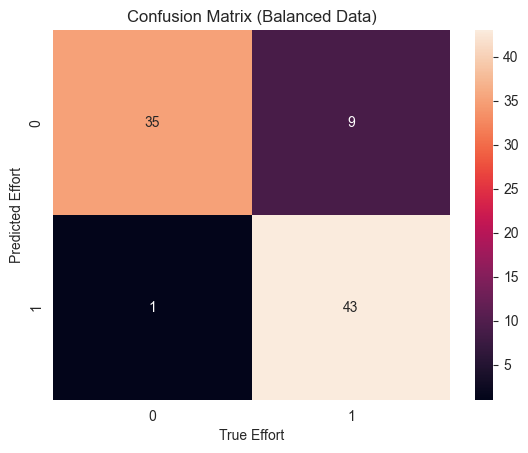


Comparison of top 20 positive and negative predictors for Effort:
   feature_pos  coefficient_pos feature_neg  coefficient_neg
0        bring         0.776293   motivates        -0.308620
1          dad         0.752852      toilet        -0.308641
2        jjust         0.707393     skibidi        -0.308641
3         tell         0.590174    somewhat        -0.308659
4      belived         0.556202       agree        -0.308659
5        didnt         0.538930       topik        -0.308678
6          got         0.517639     motived        -0.308687
7         work         0.500756        hard        -0.340237
8           im         0.491071    guessing        -0.388823
9       really         0.478314        said        -0.388860
10      pushed         0.476169        sure        -0.388860
11         let         0.466645       never        -0.401356
12      sooner         0.451299      saying        -0.411417
13      needed         0.408378        need        -0.481275
14       music    

In [127]:
# hide_input
# Select the target human code
y_raw = text_df_filtered['Effort']

# Make sure X (tfidf_df) and y share the same indices
valid_idx = tfidf_df.index.intersection(y_raw.index)

X = tfidf_df.loc[valid_idx]
y = y_raw.loc[valid_idx]
print(y.value_counts())

# Build a balanced sub-dataset with equal number of sample coded as 0 and 1

class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
n_minority = class_counts.min()

# Indices for each class
minority_idx = y[y == minority_class].index
majority_idx_sampled = y[y == majority_class].sample(
    n=n_minority,
    random_state=12434  # reproducibility
).index

balanced_idx = minority_idx.union(majority_idx_sampled)

X_bal = X.loc[balanced_idx]
y_bal = y.loc[balanced_idx]

# Shuffle rows
X_bal, y_bal = shuffle(X_bal, y_bal, random_state=14312)

print("\nBalanced class counts:")
print(y_bal.value_counts())

#Using the balanced dataset to train the machine learning logistic regression model

bal_classifier = LogisticRegression(max_iter=1000)
bal_classifier.fit(X_bal, y_bal)

print("\nClasses in classifier:", bal_classifier.classes_)

# Predict on balanced data (for quick check)
predicted_bal = bal_classifier.predict(X_bal)

# Print out the evaluation metrics

print("\nLogistic Regression Accuracy (Balanced Data):",
      metrics.accuracy_score(y_bal, predicted_bal))
print("Logistic Regression Precision (Balanced Data):",
      metrics.precision_score(y_bal, predicted_bal))
print("Logistic Regression Recall (Balanced Data):",
      metrics.recall_score(y_bal, predicted_bal))

print("\nClassification Report (Balanced Data):\n",
      metrics.classification_report(y_bal, predicted_bal))

# Confusion matrix
cm_bal = metrics.confusion_matrix(y_bal, predicted_bal)

sns.heatmap(cm_bal, annot=True, fmt='d')
plt.title('Confusion Matrix (Balanced Data)')
plt.xlabel('True Effort')
plt.ylabel('Predicted Effort')
plt.show()

# Print out the logistic coefficients for the top word list

# For binary classification in sklearn:
# bal_classifier.coef_[0] corresponds to the SECOND class in bal_classifier.classes_
positive_class = bal_classifier.classes_[1]

coef = bal_classifier.coef_[0]         # shape: (n_features,)
feature_names = X_bal.columns          # TF-IDF feature names

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
})

# Sort descending: largest positive coefficients first
coef_df_sorted = coef_df.sort_values(by='coefficient', ascending=False)

# Top words predicting the positive_class and negative_class (Top 20 for each)
top_20_pos = coef_df_sorted.head(20)
top_20_neg = coef_df_sorted.tail(20)


highest_20 = top_20_pos.reset_index(drop=True)
lowest_20 = top_20_neg.reset_index(drop=True)

highest_20.columns = [col + "_pos" for col in highest_20.columns]
lowest_20.columns = [col + "_neg" for col in lowest_20.columns]

coef_compare = pd.concat([highest_20, lowest_20], axis=1)

print("\nComparison of top 20 positive and negative predictors for Effort:")
print(coef_compare)


In [128]:
# hide_input
#Print out more positive and negative predictor words

# All words with positive coefficients (predict the positive_class)
pos_df = coef_df_sorted[coef_df_sorted['coefficient'] > 0].copy()
neg_df = coef_df_sorted[coef_df_sorted['coefficient'] < 0].copy()

pos_words = pos_df['feature'].tolist()
neg_words = neg_df['feature'].tolist()

print("\nFirst top 50 positive words for Effort:")
print(pos_words[:50])

print("\nFirst top 50 negative words for Effort:")
print(neg_words[:50])


First top 50 positive words for Effort:
['bring', 'dad', 'jjust', 'tell', 'belived', 'didnt', 'got', 'work', 'im', 'really', 'pushed', 'let', 'sooner', 'needed', 'music', 'keep', 'ghelped', 'varible', 'listen', 'could', 'something', 'knowing', 'clam', 'looked', 'confused', 'super', 'invicible', 'right', 'listened', 'home', 'set', 'end', 'goal', 'best', 'thisssss', 'good', 'mysef', 'friday', 'workspace', 'outside', 'go', 'everyone', 'ig', 'like', 'posssible', 'mean', 'material', 'tried', 'understand', 'reason']

First top 50 negative words for Effort:
['make', 'hate', 'going', 'worked', 'want', 'que', 'se', 'muy', 'dormir', 'perfesionista', 'sique', 'pongo', 'puen', 'si', 'timpo', 'soy', 'sueo', 'dibujar', 'tengo', 'pase', 'termi', 'para', 'con', 'esto', 'musica', 'eletronica', 'estreso', 'el', 'see', 'would', 'dont', 'family', 'give', 'back', 'topic', 'used', 'focused', 'people', 'learned', 'around', 'noise', 'talking', 'backround', 'cancel', 'else', 'whe', 'across', 'come', 'know', '


=== Final model for predicting Effort using top 50 positive + top 50 negative words ===
Total usable features: 100
Accuracy: 0.7840909090909091
Precision: 0.8787878787878788
Recall: 0.6590909090909091

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.91      0.81        44
         1.0       0.88      0.66      0.75        44

    accuracy                           0.78        88
   macro avg       0.80      0.78      0.78        88
weighted avg       0.80      0.78      0.78        88



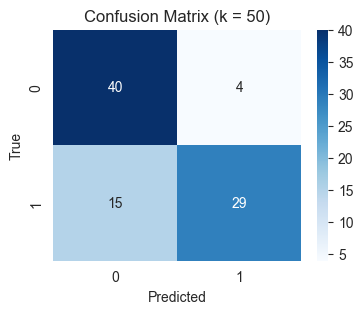

In [105]:
# hide_input
# Final evaluation with k = 50

def evaluate_final_k(X_bal, y_bal, pos_words, neg_words):

    k = 50
    print(f"\n=== Final model for predicting Effort using top {k} positive + top {k} negative words ===")

    # Select the top 50 pos + 50 neg words
    pos_k = pos_words[:k]
    neg_k = neg_words[:k]
    selected_features = pos_k + neg_k

    # Ensure the selected features exist in TF-IDF columns
    selected_features = [w for w in selected_features if w in X_bal.columns]
    print(f"Total usable features: {len(selected_features)}")

    # Subset TF-IDF matrix
    X_sub = X_bal[selected_features]

    # Train logistic regression on full dataset
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_sub, y_bal)

    # Predict on training data (you can later swap to test set if needed)
    y_pred = clf.predict(X_sub)

    # Evaluation metrics
    print("Accuracy:", metrics.accuracy_score(y_bal, y_pred))
    print("Precision:", metrics.precision_score(y_bal, y_pred))
    print("Recall:", metrics.recall_score(y_bal, y_pred))
    print("\nClassification Report:\n",
          metrics.classification_report(y_bal, y_pred))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_bal, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix (k = 50)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return clf, selected_features, cm

# =====================================
# Run final model
# =====================================
clf_50, features_50, cm_50 = evaluate_final_k(
    X_bal=X_bal,
    y_bal=y_bal,
    pos_words=pos_words,
    neg_words=neg_words
)


In [131]:
import spacy
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
from itertools import combinations


top50_pos = pos_words[:50]

# Make one anchor doc out of the 50 words
anchor_doc = nlp(" ".join(top50_pos))

# ---------------------------
# 2. Get response texts aligned with valid_idx
# ---------------------------

TEXT_COL = "input"  # change to your actual text column name
response_texts = text_df_filtered.loc[valid_idx, TEXT_COL].astype(str)

# -----------------------------------
# 2. Function: internal sentence-pair similarity
# -----------------------------------

def get_internal_similarity(text):
    doc = nlp(text)
    sents = list(doc.sents)

    # If only 1 sentence, similarity = 0 (or np.nan)
    if len(sents) < 2:
        return np.nan

    similarities = []

    # compare ALL pairs: (0,1), (0,2), (1,2), (1,3), ...
    for s1, s2 in combinations(sents, 2):
        sim = s1.similarity(s2)
        similarities.append(sim)

    # return mean similarity of all sentence pairs
    return np.mean(similarities)

# -----------------------------------
# 3. Compute similarity for each response
# -----------------------------------

semantic_scores = []
for txt in response_texts:
    sim = get_internal_similarity(txt)
    semantic_scores.append(sim)

# ---------------------------
# 4. Build results_df (keep index so we can use balanced_idx)
# ---------------------------

results_df = pd.DataFrame({
    "response_text": response_texts,
    "Effort": y.loc[valid_idx],
    "semantic_sim": semantic_scores
}, index=valid_idx)

# 5B. T-test on BALANCED subset (optional)
# ---------------------------
# This assumes you already defined `balanced_idx` earlier when you made X_bal, y_bal

results_bal = results_df.loc[balanced_idx].dropna()

sim_1_bal = results_bal.loc[results_bal["Effort"] == 1, "semantic_sim"]
sim_0_bal = results_bal.loc[results_bal["Effort"] == 0, "semantic_sim"]

t_bal, p_bal = ttest_ind(sim_1_bal, sim_0_bal, equal_var=False)

print("\nT-test (BALANCED DATA)")
print(f"T = {t_bal:.4f}, p = {p_bal:.4f}")
print(f"Mean_1 = {sim_1_bal.mean():.4f}, Mean_0 = {sim_0_bal.mean():.4f}")

/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_66931/99709630.py:36: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  sim = s1.similarity(s2)



T-test (BALANCED DATA)
T = nan, p = nan
Mean_1 = 0.9134, Mean_0 = 0.9280


/Users/zepedalab/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/zepedalab/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
